In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sqlalchemy import create_engine

# --- TiDB Cloud connection (your values) ---
HOST = "gateway01.ap-southeast-1.prod.aws.tidbcloud.com"
PORT = 4000
USER = "sJS9A4ifsRxCyhp.root"    # keep the prefix
PASSWORD = "BZOhl53om6ZM6iOO"
DB = "imdb2024"

engine = create_engine(f"mysql+mysqlconnector://{USER}:{PASSWORD}@{HOST}:{PORT}/{DB}")

In [31]:
import re

def parse_votes(v):
    if pd.isna(v):
        return np.nan
    s = str(v).strip().replace(",", "")
    s = s.replace("(", "").replace(")", "")
    if s.endswith(("K","k")):
        try: return int(float(s[:-1]) * 1_000)
        except: return np.nan
    if s.endswith(("M","m")):
        try: return int(float(s[:-1]) * 1_000_000)
        except: return np.nan
    try:
        return int(float(s))
    except:
        return np.nan

def parse_duration_to_minutes(s):
    if pd.isna(s): return np.nan
    if isinstance(s,(int,float)): return float(s)
    text = str(s).lower()
    h = re.search(r"(\d+)\s*h", text)
    m = re.search(r"(\d+)\s*m", text)
    total = 0
    if h: total += int(h.group(1)) * 60
    if m: total += int(m.group(1))
    if total > 0: return float(total)
    m2 = re.search(r"(\d+)\s*min", text)
    if m2: return float(m2.group(1))
    try: return float(text)
    except: return np.nan

def clean_columns(df):
    # rename to canonical names
    rename_map = {
        "Movie Name": "title", "Movie_Name": "title", "movie_name": "title",
        "Genre": "genre", "genre_name": "genre",
        "Ratings": "rating", "Rating": "rating",
        "Voting Counts": "votes", "Votes": "votes",
        "Duration": "duration_raw", "duration": "duration_raw",
        "Duration (min)": "duration_min", "Duration_min": "duration_min",
        "Movie": "title"
    }
    df = df.rename(columns=rename_map)

    # ensure required cols exist
    for c in ["title","genre","rating","votes","duration_raw","duration_min"]:
        if c not in df.columns:
            df[c] = np.nan

    # parse numerics
    df["rating"] = pd.to_numeric(df["rating"], errors="coerce")
    df["votes"]  = df["votes"].apply(parse_votes)
    if df["duration_min"].isna().all():
        df["duration_min"] = df["duration_raw"].apply(parse_duration_to_minutes)
    else:
        df["duration_min"] = df["duration_min"].apply(parse_duration_to_minutes)

    # genre cleanup
    df["genre"] = df["genre"].fillna("").astype(str).str.strip()
    df["genre_primary"] = df["genre"].apply(lambda g: g.split(",")[0].strip().title() if isinstance(g,str) else g)

    # title cleanup
    df = df.dropna(subset=["title"]).copy()
    df["title"] = df["title"].astype(str).str.replace(r"^\d+\.\s*", "", regex=True).str.strip()

    # numbering column S.No
    df = df.reset_index(drop=True)
   

    # derived
    df["duration_hrs"] = df["duration_min"] / 60.0
    return df


In [32]:
raw = pd.read_sql("SELECT * FROM movies", engine)
df = clean_columns(raw)

print("Shape:", df.shape)
df.head(10)

Shape: (174, 8)


,title,genre,rating,votes,duration_raw,duration_min,genre_primary,duration_hrs
0,Mahavatar Narsimha,Action,9.1,33000,2h 10m,130.0,Action,2.166667
1,Relay,Action,7.3,1900,1h 52m,112.0,Action,1.866667
2,Freaky Tales,Action,6.3,12000,1h 47m,107.0,Action,1.783333
3,Dune: Part Two,Action,8.5,661000,2h 46m,166.0,Action,2.766667
4,Gladiator II,Action,6.5,271000,2h 28m,148.0,Action,2.466667
5,The Beekeeper,Action,6.3,167000,1h 45m,105.0,Action,1.750000
6,The Ministry of Ungentlemanly Warfare,Action,6.8,144000,2h 2m,122.0,Action,2.033333
7,Deadpool & Wolverine,Action,7.5,524000,2h 8m,128.0,Action,2.133333
8,Drive-Away Dolls,Action,5.4,25000,1h 24m,84.0,Action,1.400000
9,Carry-On,Action,6.5,178000,1h 59m,119.0,Action,1.983333


In [33]:
print("=== df.info() ===")
print(df.info())

print("\n=== df.describe(numeric_only=True) ===")
display(df.describe())

print("\n=== sample rows ===")
display(df.sample(min(10, len(df))))

=== df.info() ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   title          174 non-null    object 
 1   genre          174 non-null    object 
 2   rating         174 non-null    float64
 3   votes          174 non-null    int64  
 4   duration_raw   174 non-null    object 
 5   duration_min   174 non-null    float64
 6   genre_primary  174 non-null    object 
 7   duration_hrs   174 non-null    float64
dtypes: float64(3), int64(1), object(4)
memory usage: 11.0+ KB
None

=== df.describe(numeric_only=True) ===


,rating,votes,duration_min,duration_hrs
count,174.000000,174.000000,174.000000,174.000000
mean,6.244828,65233.149425,110.580460,1.843008
std,0.850944,90724.749940,17.822888,0.297048
min,3.900000,80.000000,80.000000,1.333333
25%,5.700000,6300.000000,99.000000,1.650000
50%,6.300000,32500.000000,108.500000,1.808333
75%,6.800000,92750.000000,119.000000,1.983333
max,9.100000,661000.000000,178.000000,2.966667



=== sample rows ===


,title,genre,rating,votes,duration_raw,duration_min,genre_primary,duration_hrs
45,Cloud,Action,6.4,2400,2h 4m,124.0,Action,2.066667
10,William Tell,Action,5.7,4900,2h 14m,134.0,Action,2.233333
82,A Family Affair,Comedy,5.4,38000,1h 51m,111.0,Comedy,1.850000
73,Snack Shack,Comedy,7.0,14000,1h 52m,112.0,Comedy,1.866667
58,Spermageddon,Comedy,5.4,2000,1h 20m,80.0,Comedy,1.333333
8,Drive-Away Dolls,Action,5.4,25000,1h 24m,84.0,Action,1.400000
153,Salem's Lot,Horror,5.6,37000,1h 54m,114.0,Horror,1.900000
167,The First Omen,Horror,6.5,67000,1h 59m,119.0,Horror,1.983333
92,Speak No Evil,Thriller,6.8,118000,1h 50m,110.0,Thriller,1.833333
80,A Different Man,Comedy,6.9,34000,1h 52m,112.0,Comedy,1.866667


In [34]:
print("=== Missing values per column ===")
display(df.isna().sum())

# optional: simple duplicate check on titles (you can adjust rule)
dupes = df[df.duplicated(subset=["title"], keep=False)].sort_values("title")
print("\n=== Possible duplicate titles (if any) ===")
display(dupes if not dupes.empty else "No obvious duplicates by title.")

=== Missing values per column ===


title            0
genre            0
rating           0
votes            0
duration_raw     0
duration_min     0
genre_primary    0
duration_hrs     0
dtype: int64


=== Possible duplicate titles (if any) ===


'No obvious duplicates by title.'

In [35]:
df_agg = df.groupby("title").agg({
    "genre": lambda x: ", ".join(sorted(set(x))),
    "rating": "first",
    "votes": "first",
    "duration_raw": "first",
    "duration_min": "first"
}).reset_index()


In [36]:
# expand multi-genre rows into separate rows for EDA
df_expanded = (
    df.copy()
      .assign(genre=df['genre'].str.split(r',\s*'))  # split into lists (handles comma + spaces)
      .explode('genre')                              # expand into multiple rows
      .assign(genre=lambda x: x['genre'].str.strip())  # clean up whitespace
      .reset_index(drop=True)
)

print("Shape after genre expansion:", df_expanded.shape)
print(df_expanded.head(10))


Shape after genre expansion: (174, 8)
                                   title   genre  rating   votes duration_raw  \
0                     Mahavatar Narsimha  Action     9.1   33000       2h 10m   
1                                  Relay  Action     7.3    1900       1h 52m   
2                           Freaky Tales  Action     6.3   12000       1h 47m   
3                         Dune: Part Two  Action     8.5  661000       2h 46m   
4                           Gladiator II  Action     6.5  271000       2h 28m   
5                          The Beekeeper  Action     6.3  167000       1h 45m   
6  The Ministry of Ungentlemanly Warfare  Action     6.8  144000        2h 2m   
7                   Deadpool & Wolverine  Action     7.5  524000        2h 8m   
8                       Drive-Away Dolls  Action     5.4   25000       1h 24m   
9                               Carry-On  Action     6.5  178000       1h 59m   

   duration_min genre_primary  duration_hrs  
0         130.0        A

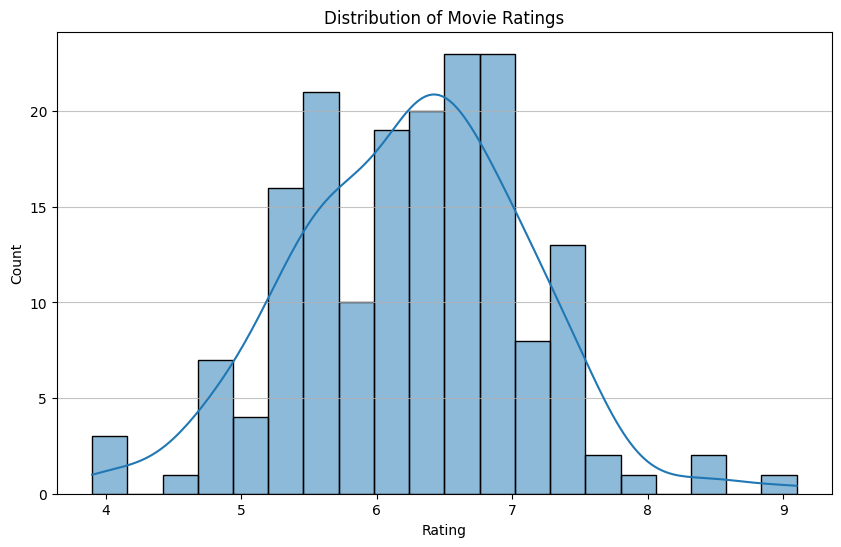

In [37]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of Movie Ratings
plt.figure(figsize=(10, 6))
sns.histplot(df['rating'], kde=True, bins=20)
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.grid(axis='y', alpha=0.75)
plt.show()


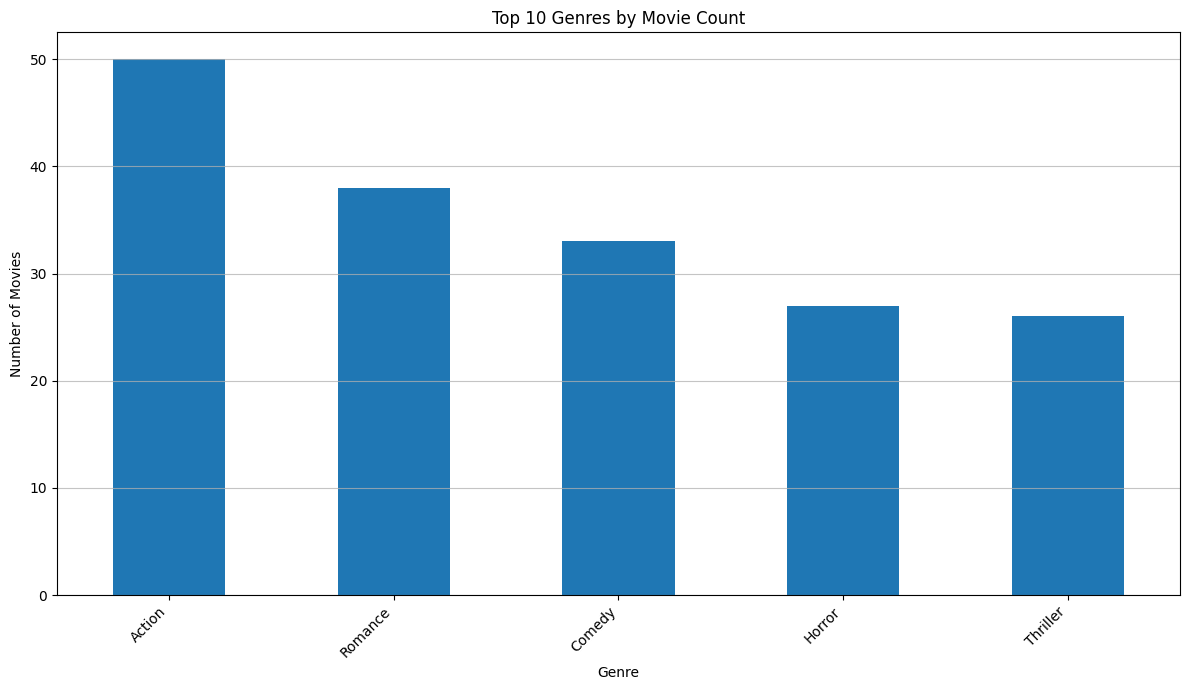

In [38]:
# Top 10 Genres by Movie Count
plt.figure(figsize=(12, 7))
df['genre_primary'].value_counts().nlargest(10).plot(kind='bar')
plt.title('Top 10 Genres by Movie Count')
plt.xlabel('Genre')
plt.ylabel('Number of Movies')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.75)
plt.tight_layout()
plt.show()


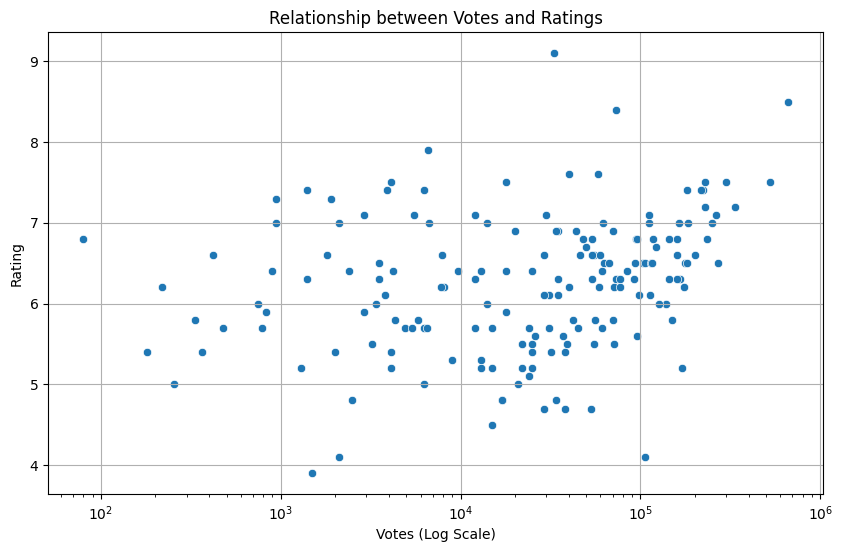

In [39]:
# Relationship between Rating and Votes
plt.figure(figsize=(10, 6))
sns.scatterplot(x='votes', y='rating', data=df)
plt.title('Relationship between Votes and Ratings')
plt.xlabel('Votes (Log Scale)')
plt.ylabel('Rating')
plt.xscale('log')
plt.grid(True)
plt.show()

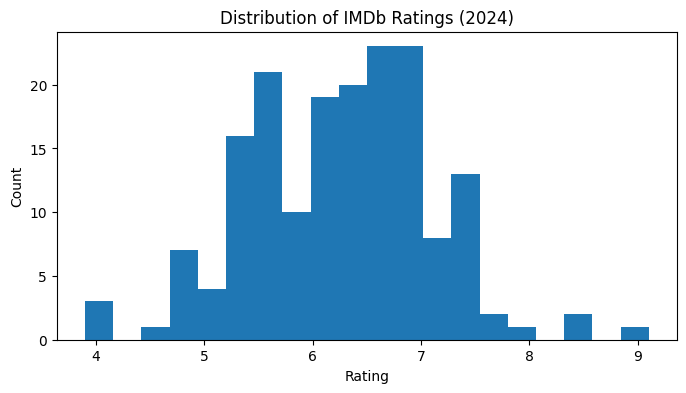

In [40]:
plt.figure(figsize=(8,4))
plt.hist(df["rating"].dropna(), bins=20)
plt.xlabel("Rating")
plt.ylabel("Count")
plt.title("Distribution of IMDb Ratings (2024)")
plt.show()

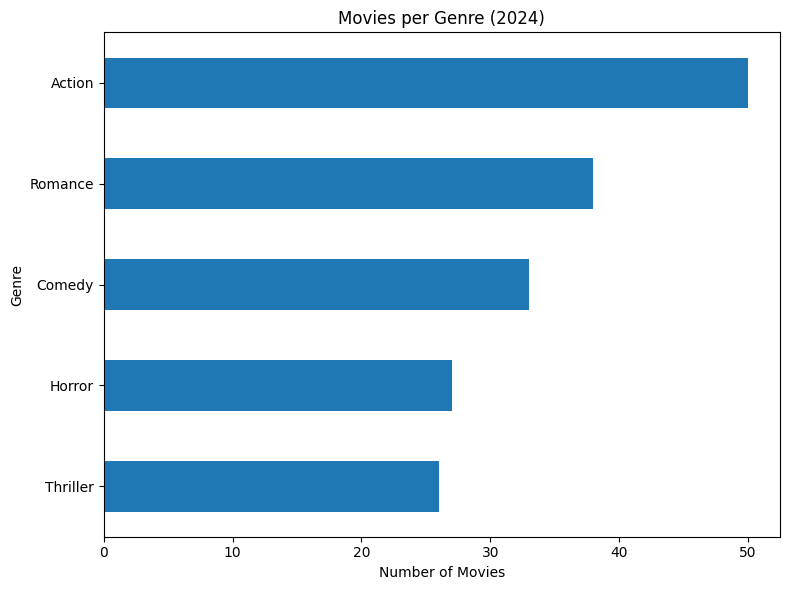

In [41]:
genre_counts = df.groupby("genre_primary")["title"].count().sort_values(ascending=True)
plt.figure(figsize=(8,6))
genre_counts.plot(kind="barh")
plt.xlabel("Number of Movies")
plt.ylabel("Genre")
plt.title("Movies per Genre (2024)")
plt.tight_layout()
plt.show()


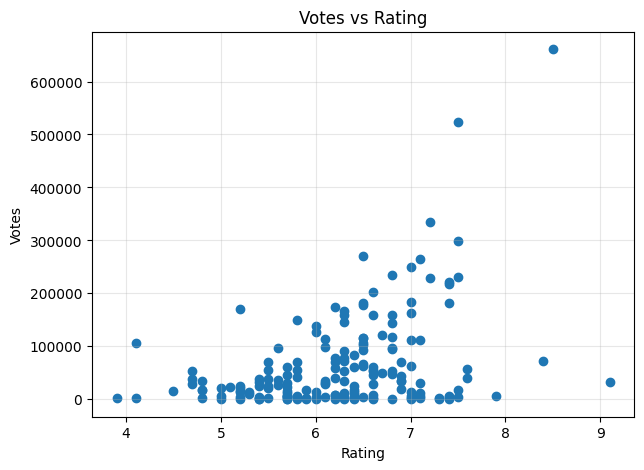

In [42]:
plt.figure(figsize=(7,5))
plt.scatter(df["rating"], df["votes"])
plt.xlabel("Rating")
plt.ylabel("Votes")
plt.title("Votes vs Rating")
plt.grid(True, alpha=0.3)
plt.show()


<Figure size 900x600 with 0 Axes>

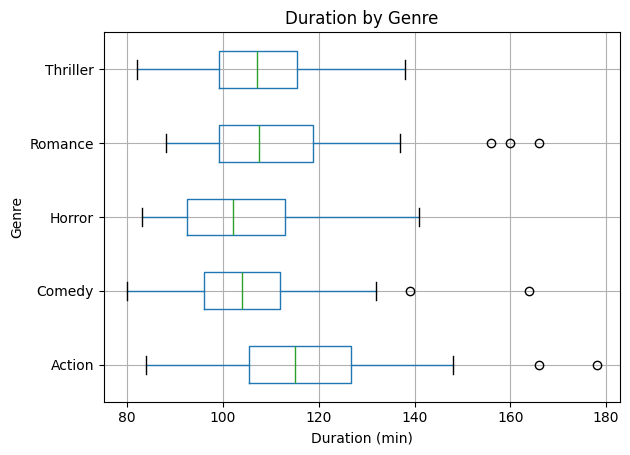

In [43]:
# keep genres with enough samples for a cleaner boxplot
counts = df["genre_primary"].value_counts()
keep_genres = counts[counts >= 5].index.tolist() if (counts >= 5).any() else counts.index.tolist()
df_box = df[df["genre_primary"].isin(keep_genres)]

plt.figure(figsize=(9,6))
df_box.boxplot(column="duration_min", by="genre_primary", vert=False)
plt.xlabel("Duration (min)")
plt.ylabel("Genre")
plt.title("Duration by Genre")
plt.suptitle("")  # remove automatic super-title
plt.tight_layout()
plt.show()


In [44]:
import os
os.makedirs("analysis/figures", exist_ok=True)

plt.figure(figsize=(8,4))
plt.hist(df["rating"].dropna(), bins=20)
plt.title("Distribution of Ratings")
plt.savefig("analysis/figures/rating_distribution.png", bbox_inches="tight")
plt.close()

genre_counts.plot(kind="barh", figsize=(8,6), title="Movies per Genre")
plt.savefig("analysis/figures/genre_counts.png", bbox_inches="tight")
plt.close()

plt.figure(figsize=(7,5))
plt.scatter(df["rating"], df["votes"])
plt.title("Votes vs Rating")
plt.xlabel("Rating"); plt.ylabel("Votes")
plt.savefig("analysis/figures/votes_vs_rating.png", bbox_inches="tight")
plt.close()


In [45]:
print(df.columns)
print(df.head())

Index(['title', 'genre', 'rating', 'votes', 'duration_raw', 'duration_min',
       'genre_primary', 'duration_hrs'],
      dtype='object')
                title   genre  rating   votes duration_raw  duration_min  \
0  Mahavatar Narsimha  Action     9.1   33000       2h 10m         130.0   
1               Relay  Action     7.3    1900       1h 52m         112.0   
2        Freaky Tales  Action     6.3   12000       1h 47m         107.0   
3      Dune: Part Two  Action     8.5  661000       2h 46m         166.0   
4        Gladiator II  Action     6.5  271000       2h 28m         148.0   

  genre_primary  duration_hrs  
0        Action      2.166667  
1        Action      1.866667  
2        Action      1.783333  
3        Action      2.766667  
4        Action      2.466667  


In [46]:
print(df['duration_min'].isnull().sum())
print(df['duration_hrs'].isnull().sum())


0
0


In [48]:
# If your dataset doesn't have duration_max, create one (copy of duration_min)
df["duration_max"] = df["duration_min"]

# Now you can use it
longest = df.sort_values("duration_max", ascending=False).head(5)[
    ["title", "genre", "duration_max", "rating"]
]